In [1]:
from __future__ import print_function
!export CUDA_VISIBLE_DEVICES=1 

import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
import tensorflow as tf
import time
import matplotlib.pyplot as plt
%matplotlib inline

import send_message as sm
import warnings 
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
luna_path = '/root/Cloud/Dataset/Tianchi_MedicalAI/'
working_path = luna_path + 'npy/'

K.set_image_dim_ordering('th')  # Theano dimension ordering in this code

img_rows = 512
img_cols = 512

h,w=512,512


In [3]:
def array_stats(*args):
    for X in args:
        X=np.asarray(X)
        print('array shape: ', X.shape, X.dtype)
        #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
        print('min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X)))
# preprocess
def preprocess(X,Y,param_prep):
    # X,Y: n,c,h,w
    N,C,H,W=X.shape
    
    # get params
    h=param_prep['h']
    w=param_prep['w']    
    crop=param_prep['crop']
    norm_type=param_prep['norm_type'] # normalization 
    
    
    # center crop h*w
    if crop is 'center':
        hc=(H-h)/2
        wc=(W-w)/2
        X=X[:,:,hc:H-hc,wc:W-wc]
        Y=Y[:,:,hc:H-hc,wc:W-wc]
    elif crop is 'random':
        hc=(H-h)/2
        wc=(W-w)/2
        hcr=np.random.randint(hc)
        wcr=np.random.randint(wc)
        X=X[:,:,hc:H-hc,wc:W-wc]
        Y=Y[:,:,hc:H-hc,wc:W-wc]
        
    # check if need to downsample
    # resize if needed
    if h<H:
        X_r=np.zeros([N,C,h,w],dtype=X.dtype)
        Y_r=np.zeros([N,C,h,w],dtype=Y.dtype)
        for k1 in range(X.shape[0]):
            X_r[k1] = cv2.resize(X[k1,0], (w, h), interpolation=cv2.INTER_CUBIC)
            Y_r[k1] = cv2.resize(Y[k1,0], (w, h), interpolation=cv2.INTER_CUBIC)
    else:
        X_r=X
        Y_r=Y
    
    # normalization
    X_r=np.array(X_r,dtype='float32')
    if norm_type is 'global':
        X_r-=np.mean(X_r)
        X_r/=np.std(X_r)
    elif norm_type is 'local':
        for k in range(X_r.shape[0]):
            mean = np.mean(X_r[k,0])  # mean       
            sigma = np.std(X_r[k,0])  # std
            if sigma<1e-5:
                sigma=1
            X_r[k] = X_r[k]-mean
            X_r[k] = X_r[k]/ sigma
    elif norm_type is 'scale':
        X_r-=np.min(X_r)
        X_r/=np.max(X_r)
            
    return X_r,Y_r


In [4]:
use_existing = False
print('-'*30)
print('Loading and preprocessing train data...')
print('-'*30)
X_train = np.load(working_path+"trainImages.npy").astype(np.float32)
Y_train = np.load(working_path+"trainMasks.npy").astype(np.float32)

X_test = np.load(working_path+"testImages.npy").astype(np.float32)
Y_test = np.load(working_path+"testMasks.npy").astype(np.float32)

print('-'*30)
array_stats(X_train)
print('-'*30)
array_stats(Y_train)
print('-'*30)
array_stats(X_test)
print('-'*30)
array_stats(Y_test)

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
array shape:  (2326, 1, 512, 512) float32
min: -0.821098446846, max: 0.835738241673, avg: -0.000131, std:0.162
------------------------------
array shape:  (2326, 1, 512, 512) float32
min: 0.0, max: 1.0, avg: 0.00681, std:0.0823
------------------------------
array shape:  (581, 1, 512, 512) float32
min: -0.576284468174, max: 0.822054445744, avg: -0.000132, std:0.161
------------------------------
array shape:  (581, 1, 512, 512) float32
min: 0.0, max: 1.0, avg: 0.00601, std:0.0773


In [5]:
# pre-processing 
param_prep={
    'h': h,
    'w': w,
    'crop'    : None,
    'norm_type' : None,
}

print('wait ...')
# preprocess train data
X_train_r,Y_train_r=preprocess(X_train,Y_train,param_prep)
array_stats(X_train_r)
array_stats(Y_train_r)


print('wait ...')
# preprocess train data
X_test_r,Y_test_r=preprocess(X_test,Y_test,param_prep)
array_stats(X_test_r)
array_stats(Y_test_r)


wait ...
array shape:  (2326, 1, 512, 512) float32
min: -0.821098446846, max: 0.835738241673, avg: -0.000131, std:0.162
array shape:  (2326, 1, 512, 512) float32
min: 0.0, max: 1.0, avg: 0.00681, std:0.0823
wait ...
array shape:  (581, 1, 512, 512) float32
min: -0.576284468174, max: 0.822054445744, avg: -0.000132, std:0.161
array shape:  (581, 1, 512, 512) float32
min: 0.0, max: 1.0, avg: 0.00601, std:0.0773


slices: [ 547 2185  227  334  848 2132 1792  795]
wait ...
slices: [ 547 2185  227  334  848 2132 1792  795]
wait ...


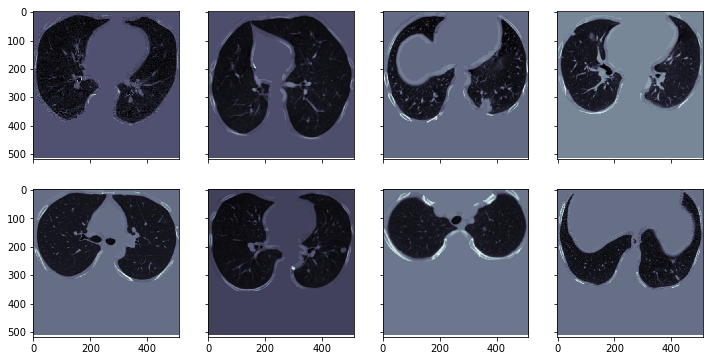

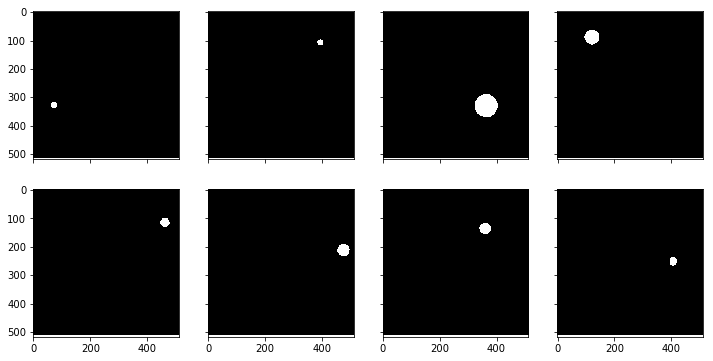

In [6]:
N_train=len(X_train)
N_test=len(X_test)

# display sample image
r,c=2,4
nb_slices=X_train.shape[0]
rnd_inds=np.random.randint(nb_slices,size=r*c)

print('slices:', rnd_inds)
f, plots = plt.subplots(r, c, sharex='all', sharey='all', figsize=(c*3, r*3))
print('wait ...')
for i in range(r*c):
    #plots[i // c, i % c].axis('off')
    plots[i // c, i % c].imshow(X_train_r[rnd_inds[i],0], cmap=plt.cm.bone)

# display sample image
r,c=2,4
nb_slices=Y_train.shape[0]
#rnd_inds=np.random.randint(nb_slices,size=r*c)

print('slices:', rnd_inds)
f, plots = plt.subplots(r, c, sharex='all', sharey='all', figsize=(c*3, r*3))
print('wait ...')
for i in range(r*c):
    #plots[i // c, i % c].axis('off')
    plots[i // c, i % c].imshow(Y_train_r[rnd_inds[i],0], cmap=plt.cm.bone)

In [7]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    smooth = 1.
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [8]:
def get_unet():
    inputs = Input((1,img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model


In [9]:
use_existing = True

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True  
sess = tf.Session(config=config)  

with tf.device('/gpu:7'):
    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    # Saving weights to unet.hdf5 at checkpoints
    model_checkpoint = ModelCheckpoint('../best_unet.hdf5', monitor='loss', save_best_only=True)
    #
    # Should we load existing weights? 
    # Set argument for call to train_and_predict to true at end of script
    if use_existing:
        model.load_weights('../best_unet.hdf5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    num_test = len(X_test_r)
    imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)
    for i in range(num_test):
        imgs_mask_test[i] = model.predict([X_test_r[i:i+1]], verbose=0)[0]
    np.save('masksTestPredicted.npy', imgs_mask_test)
    mean = 0.0
    for i in range(num_test):
        mean+=dice_coef_np(Y_test_r[i,0], imgs_mask_test[i,0])
    mean/=num_test
    print("Mean Dice Coeff : ",mean)

------------------------------
Creating and compiling model...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
Mean Dice Coeff :  0.339587159829


In [10]:
print(imgs_mask_test.shape)

(581, 1, 512, 512)


In [11]:
print(X_test_r.shape)

(581, 1, 512, 512)


图片的第 0 层


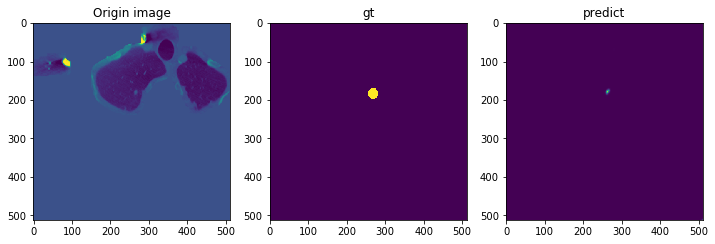

图片的第 1 层


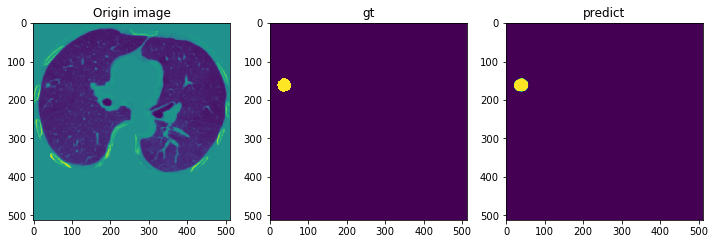

图片的第 2 层


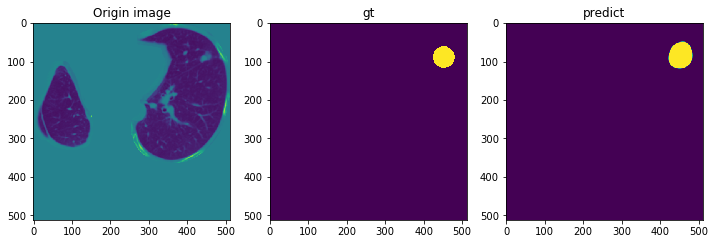

图片的第 3 层


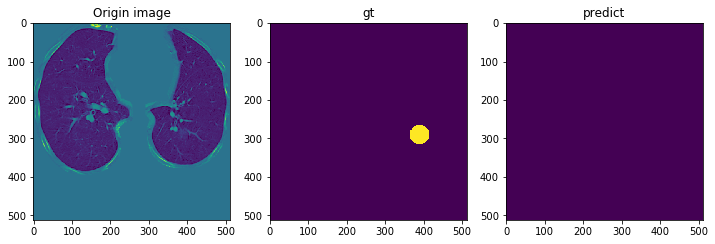

图片的第 4 层


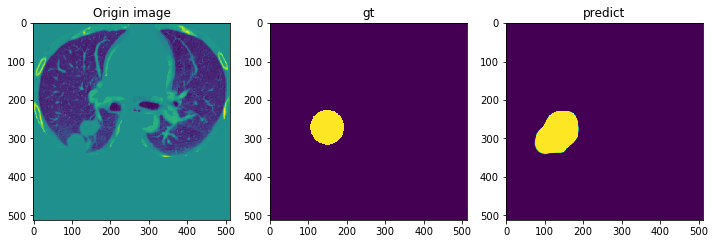

图片的第 5 层


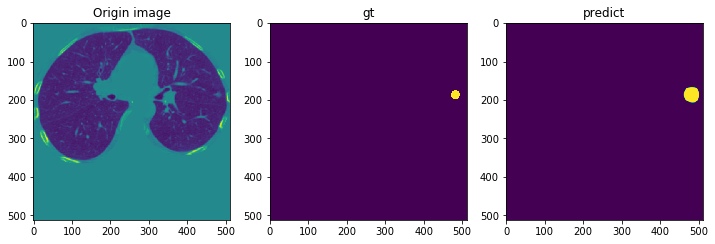

图片的第 6 层


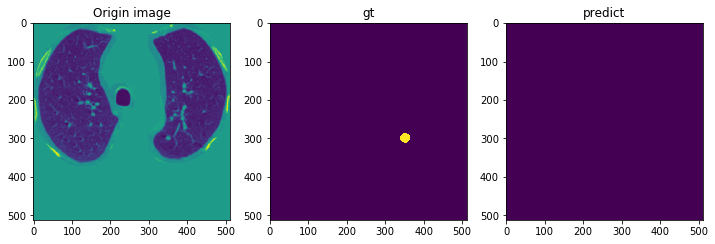

图片的第 7 层


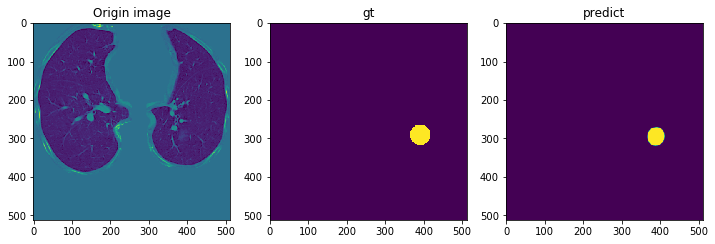

图片的第 8 层


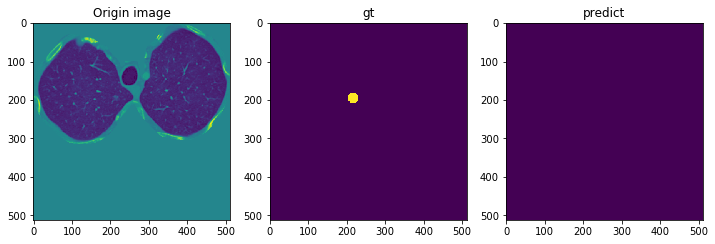

图片的第 9 层


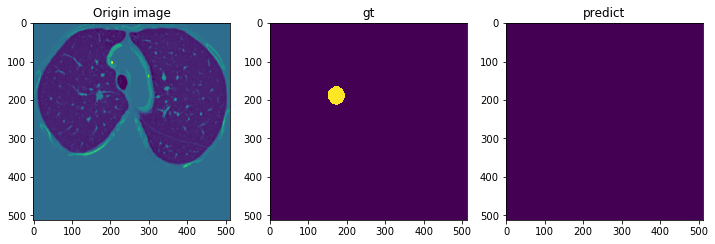

图片的第 10 层


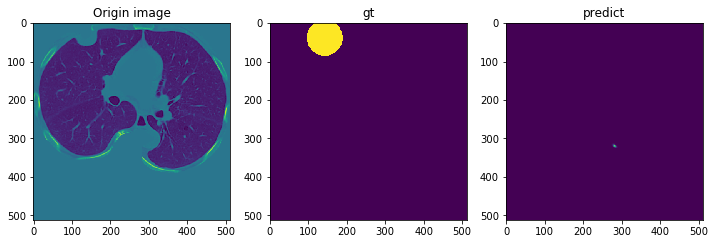

图片的第 11 层


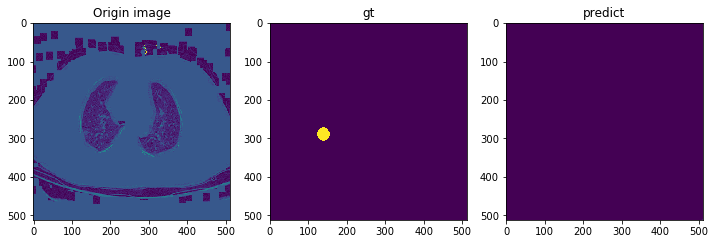

图片的第 12 层


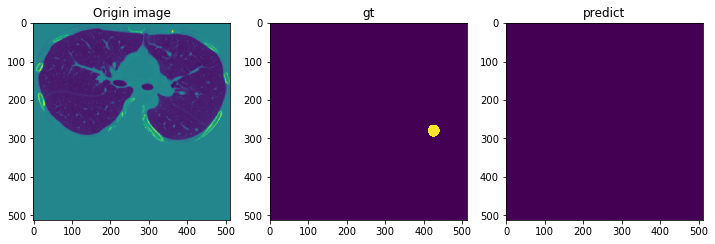

图片的第 13 层


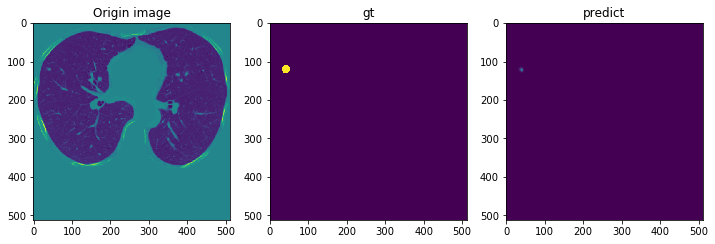

图片的第 14 层


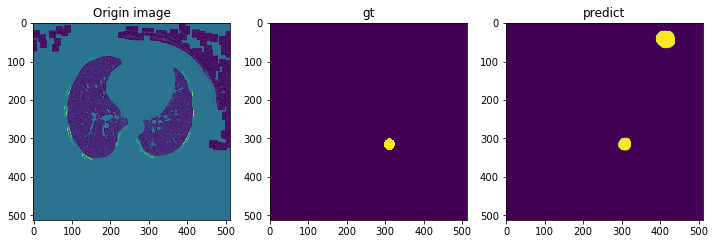

图片的第 15 层


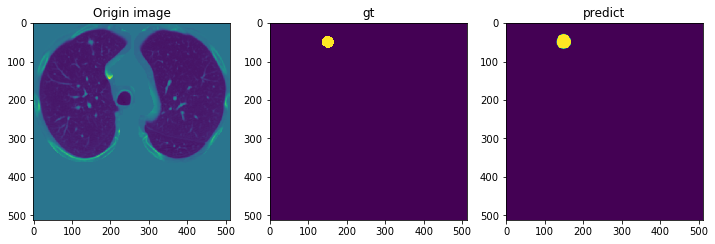

图片的第 16 层


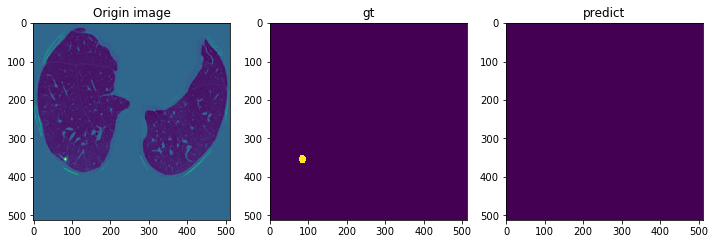

图片的第 17 层


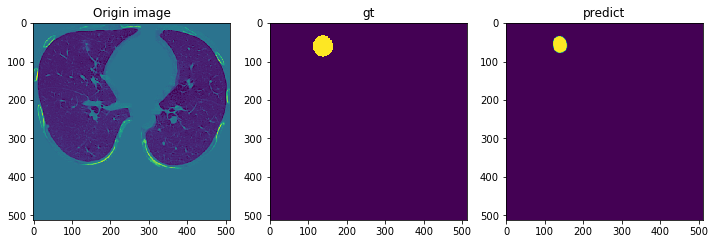

图片的第 18 层


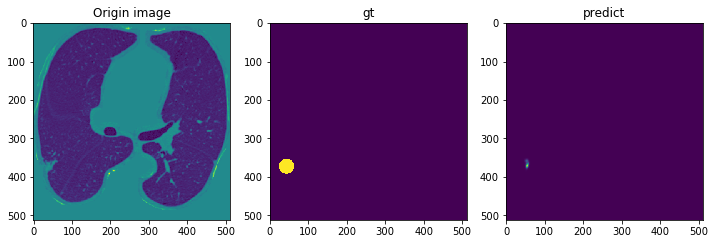

图片的第 19 层


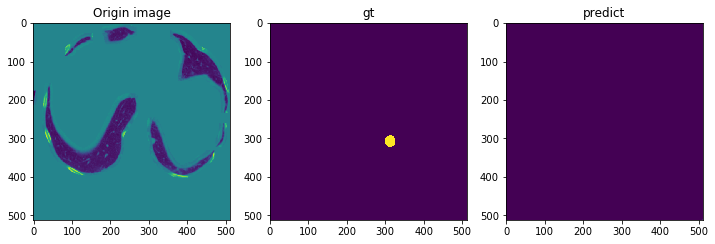

图片的第 20 层


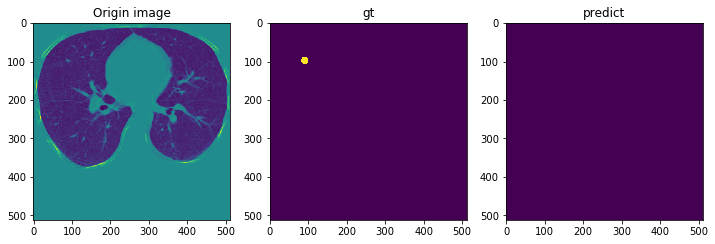

图片的第 21 层


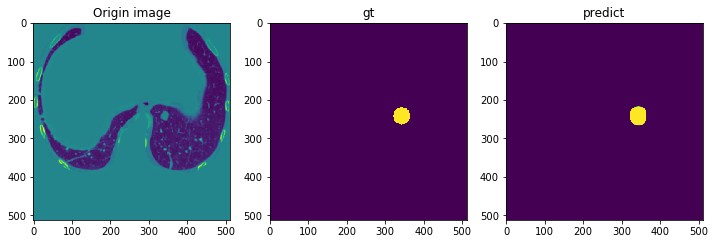

图片的第 22 层


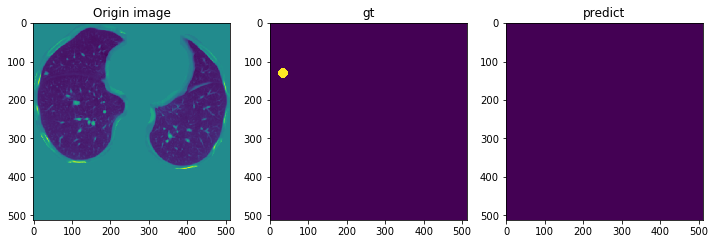

图片的第 23 层


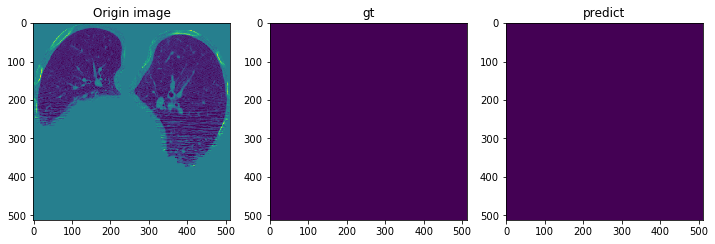

图片的第 24 层


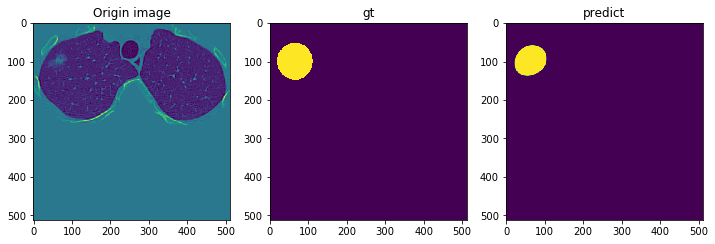

图片的第 25 层


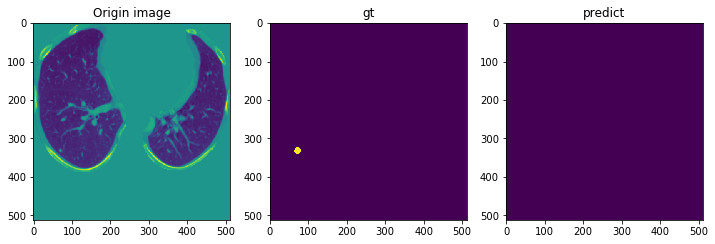

图片的第 26 层


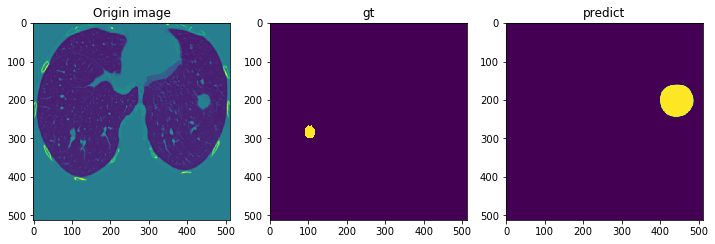

图片的第 27 层


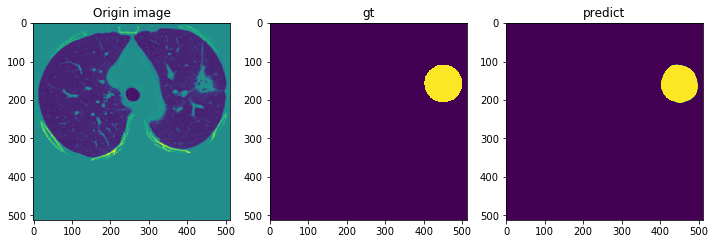

图片的第 28 层


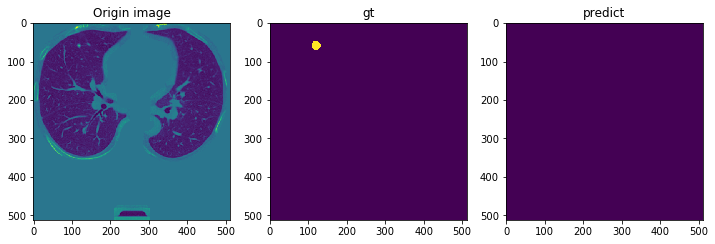

图片的第 29 层


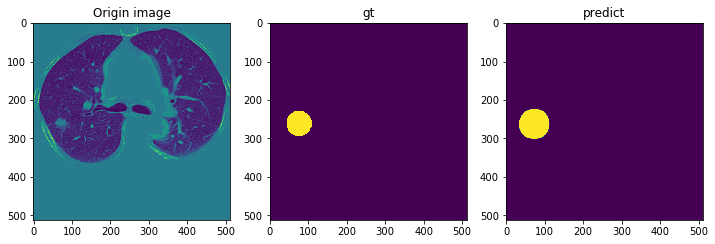

图片的第 30 层


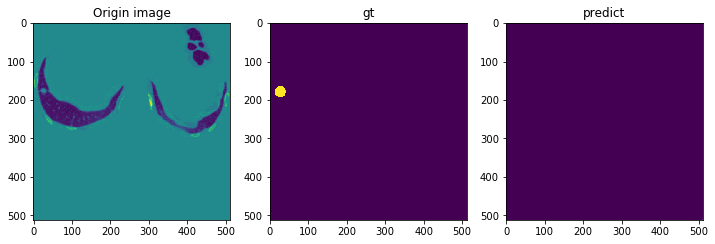

图片的第 31 层


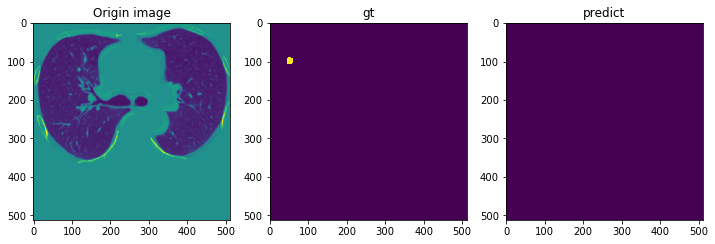

图片的第 32 层


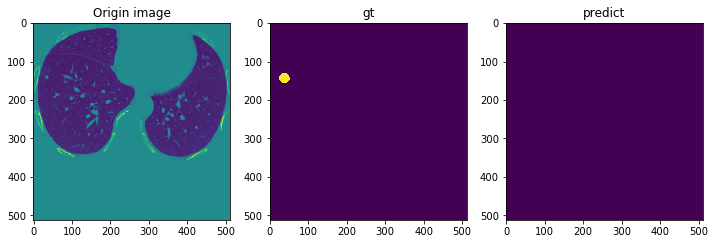

图片的第 33 层


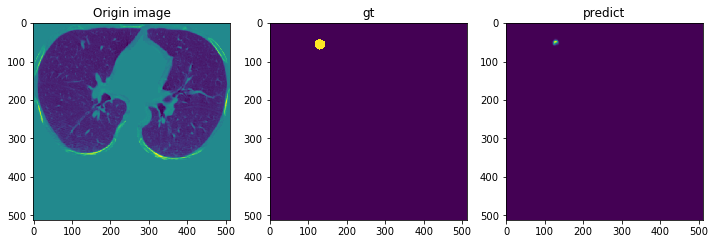

图片的第 34 层


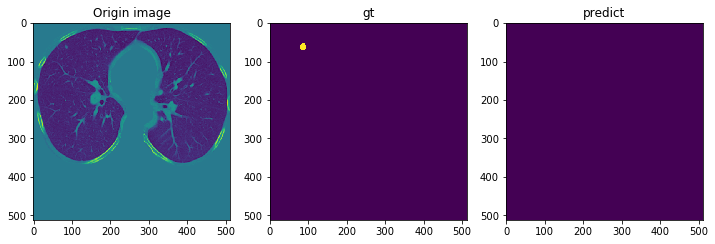

图片的第 35 层


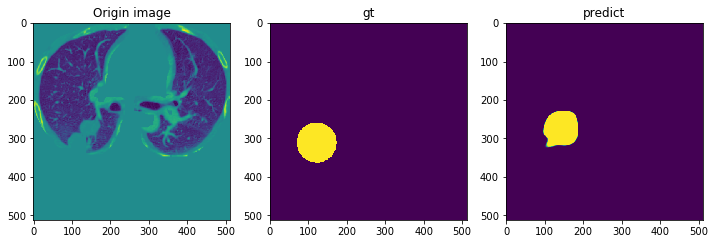

图片的第 36 层


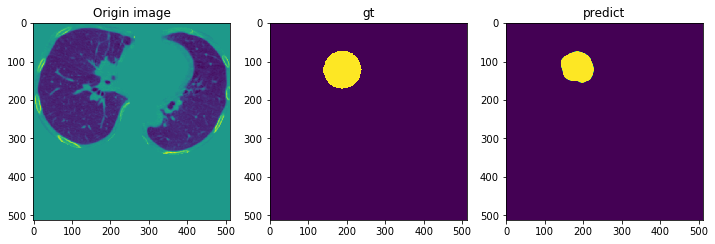

图片的第 37 层


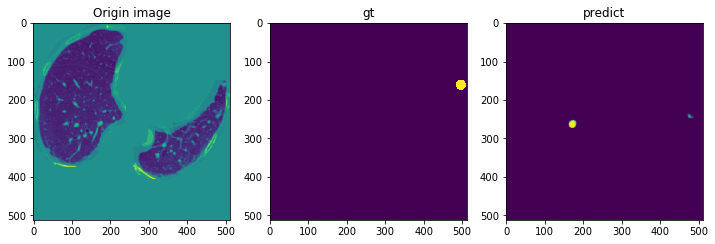

图片的第 38 层


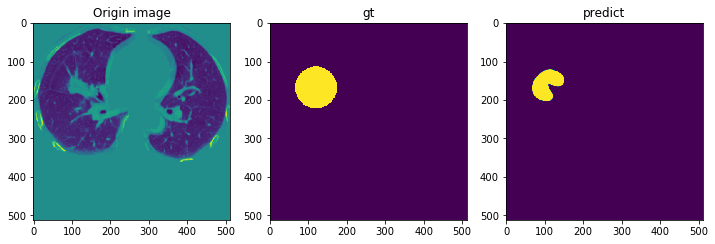

图片的第 39 层


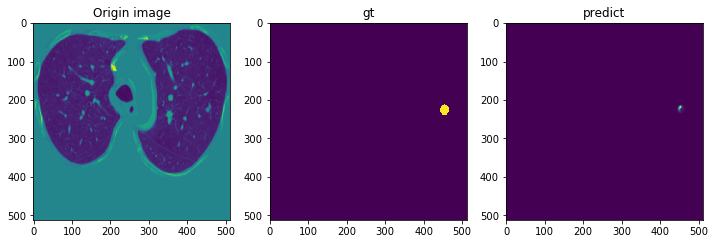

图片的第 40 层


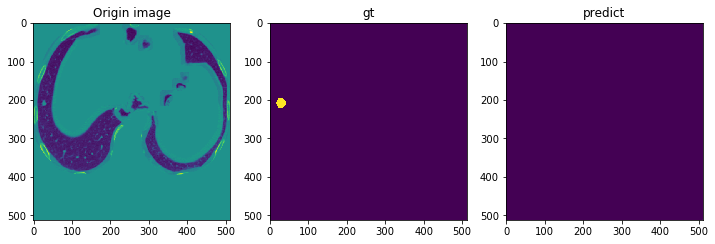

图片的第 41 层


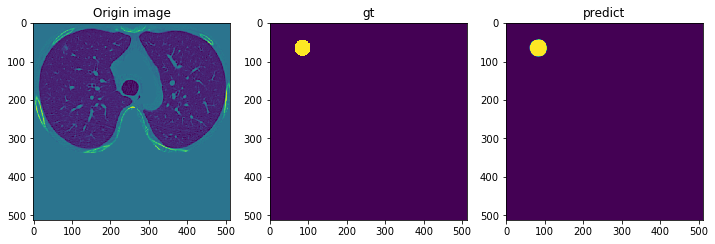

图片的第 42 层


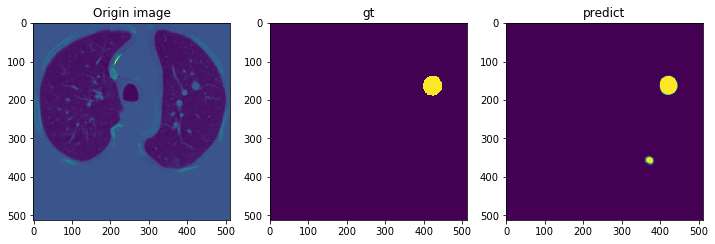

图片的第 43 层


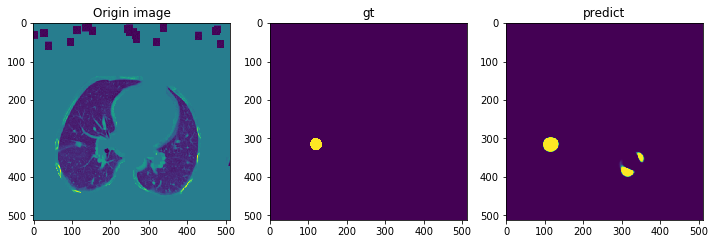

图片的第 44 层


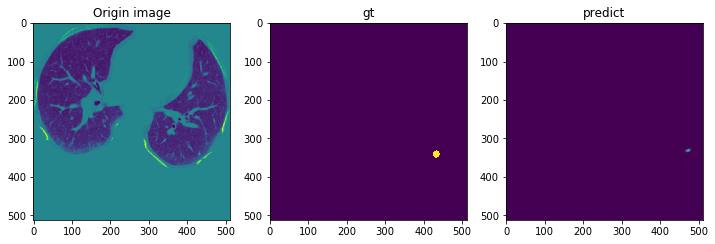

图片的第 45 层


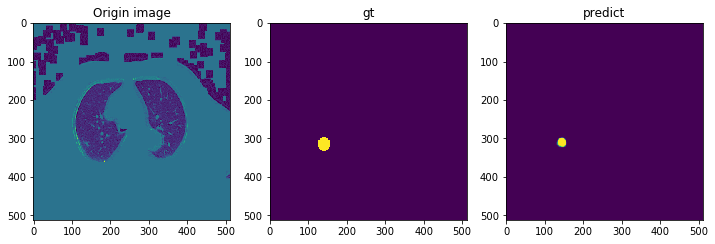

图片的第 46 层


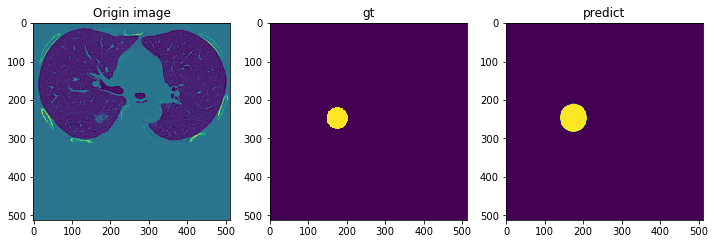

图片的第 47 层


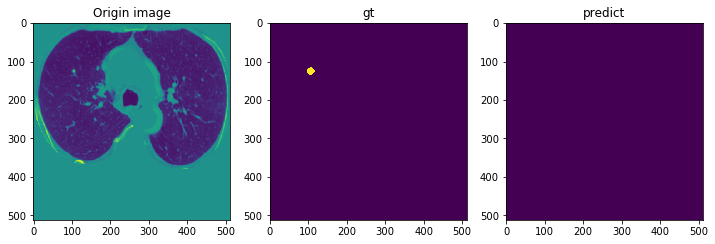

图片的第 48 层


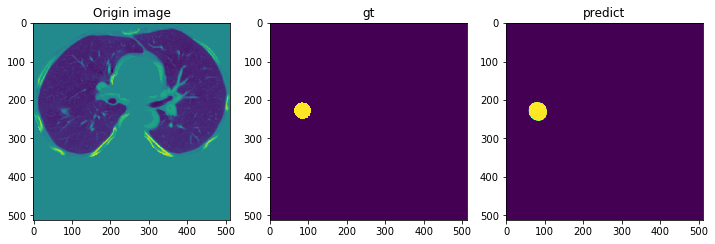

图片的第 49 层


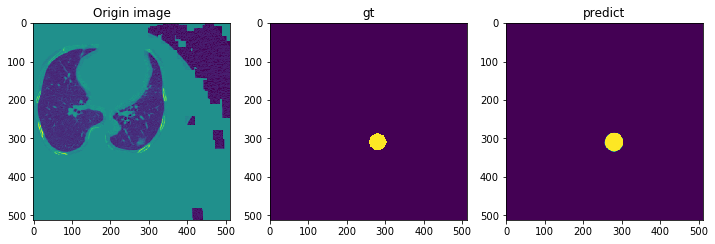

图片的第 50 层


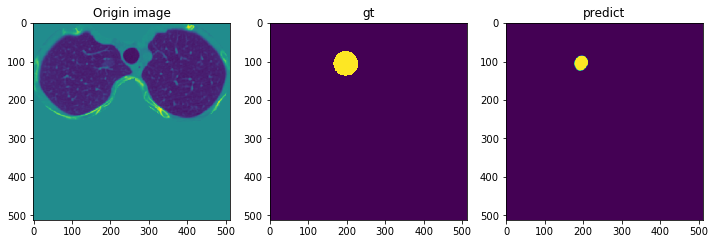

图片的第 51 层


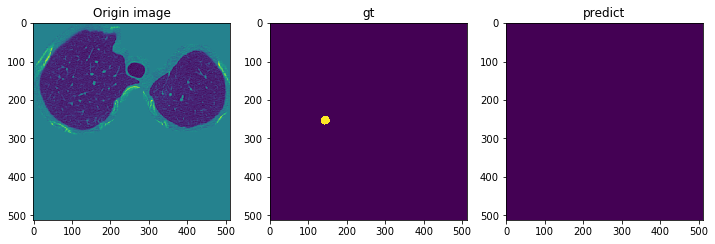

图片的第 52 层


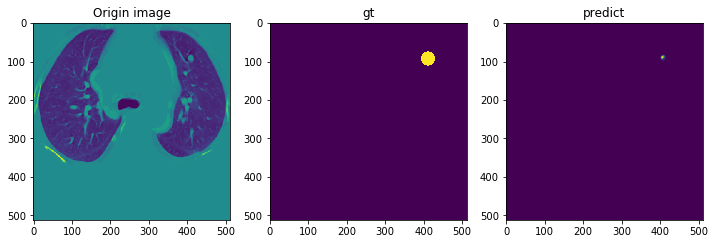

图片的第 53 层


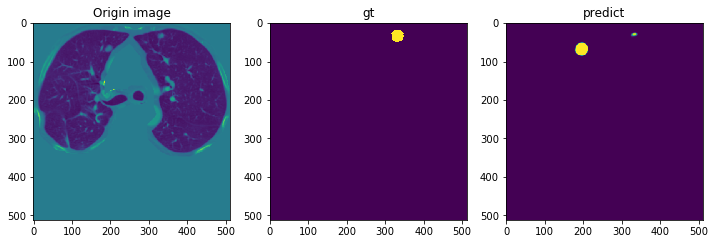

图片的第 54 层


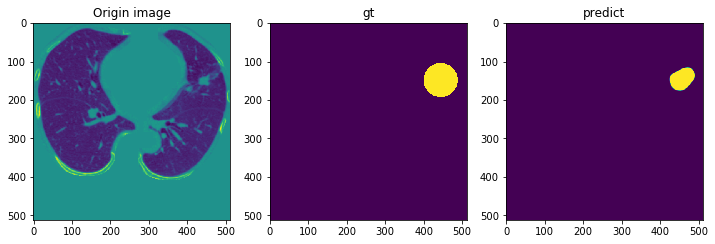

图片的第 55 层


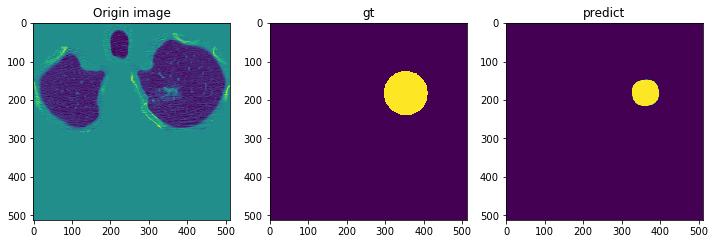

图片的第 56 层


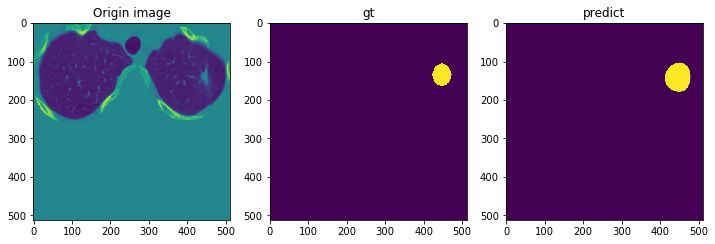

图片的第 57 层


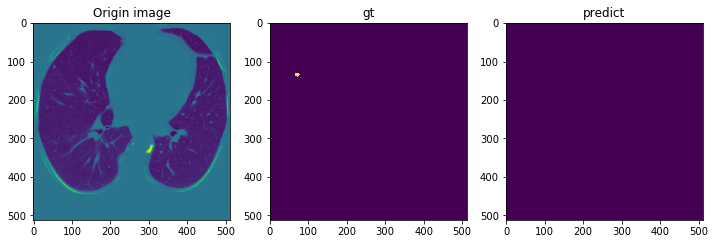

图片的第 58 层


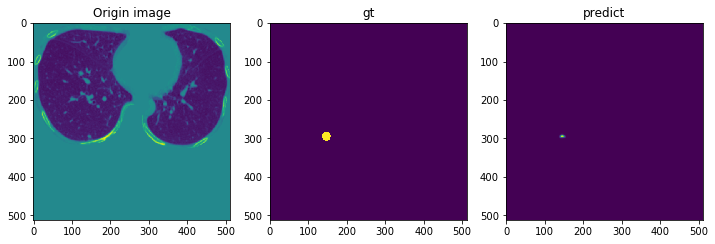

图片的第 59 层


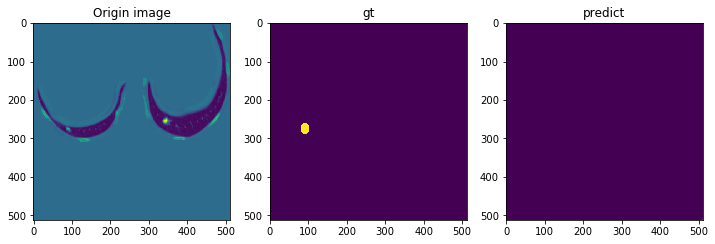

图片的第 60 层


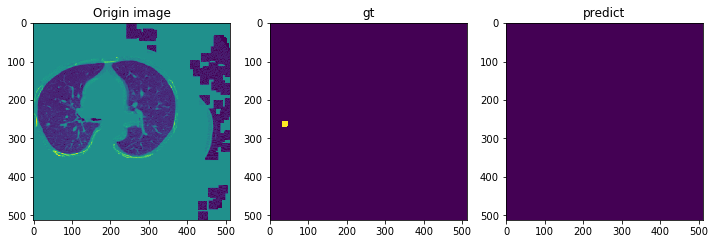

图片的第 61 层


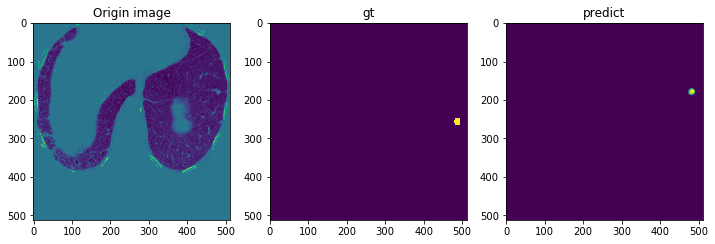

图片的第 62 层


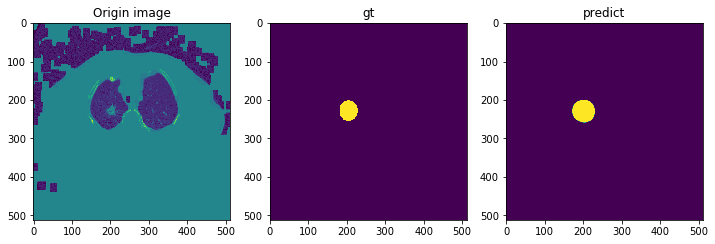

图片的第 63 层


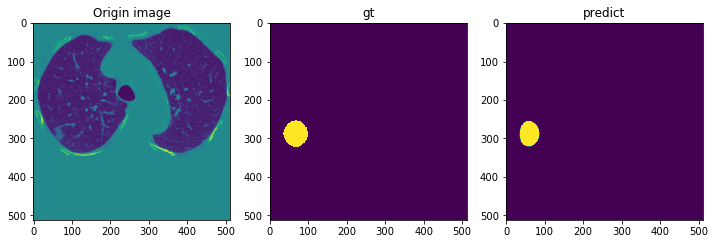

图片的第 64 层


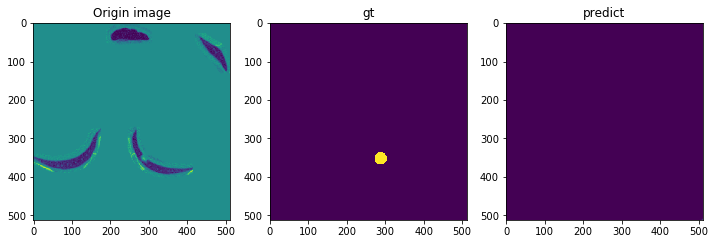

图片的第 65 层


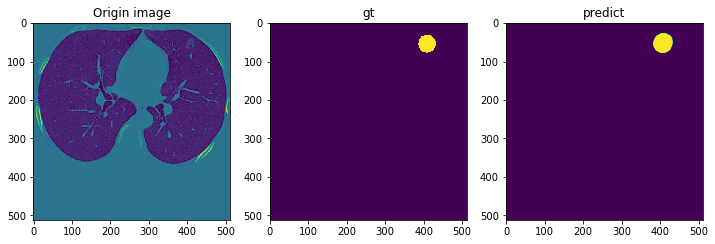

图片的第 66 层


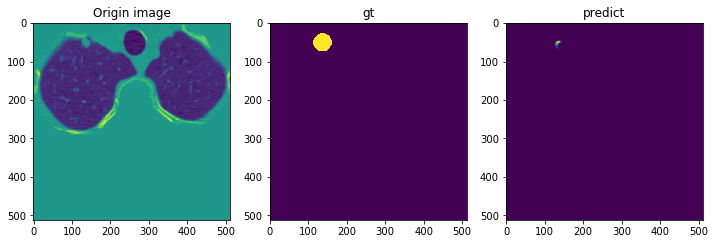

图片的第 67 层


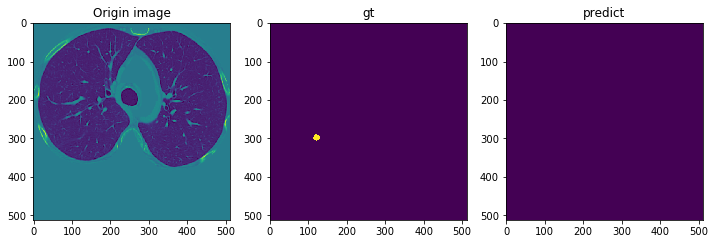

图片的第 68 层


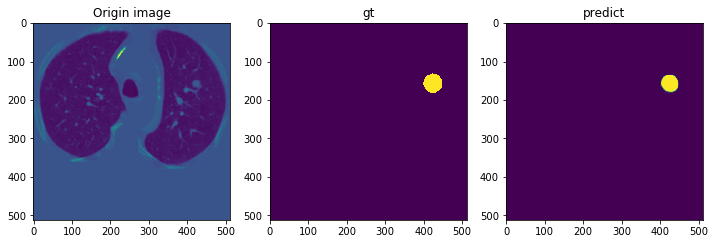

图片的第 69 层


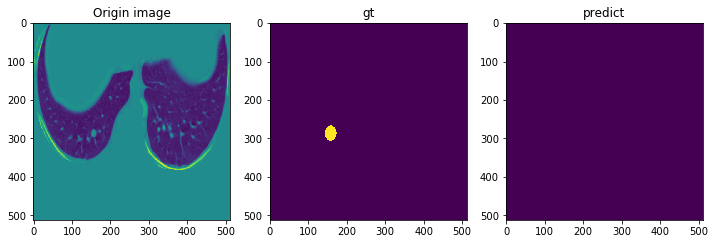

图片的第 70 层


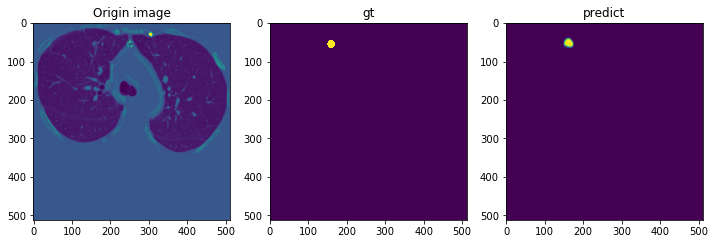

图片的第 71 层


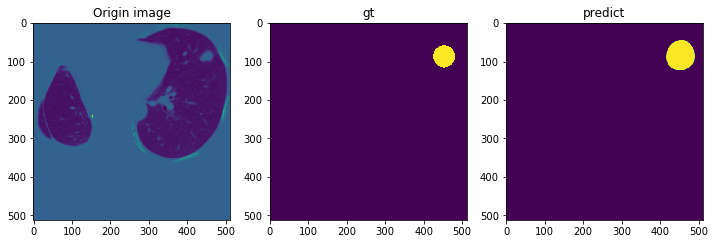

图片的第 72 层


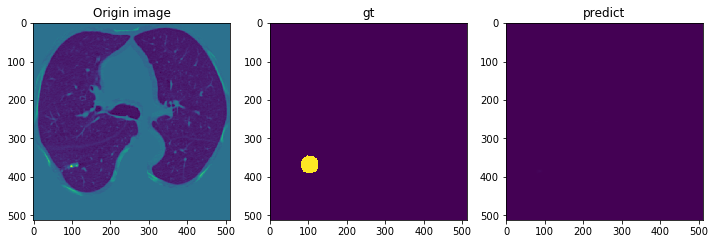

图片的第 73 层


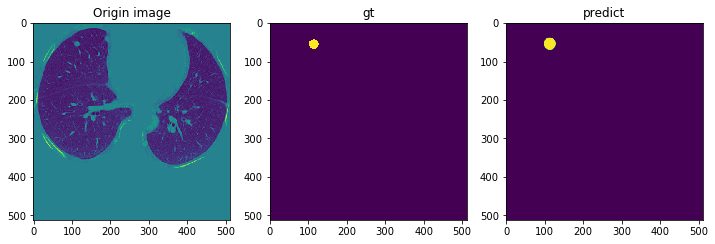

图片的第 74 层


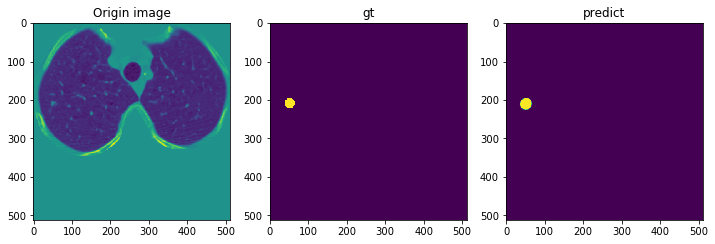

图片的第 75 层


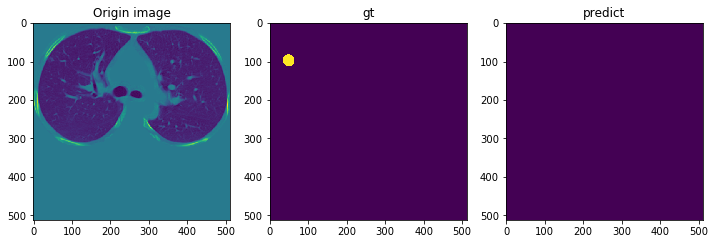

图片的第 76 层


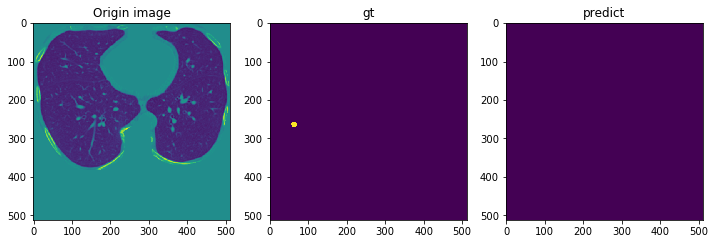

图片的第 77 层


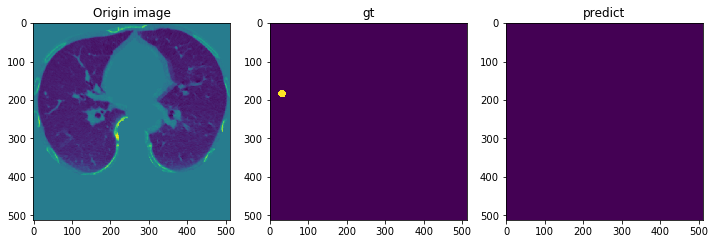

图片的第 78 层


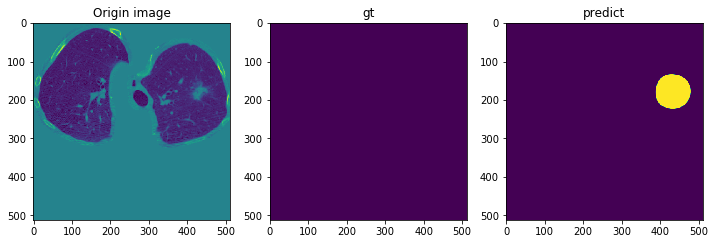

图片的第 79 层


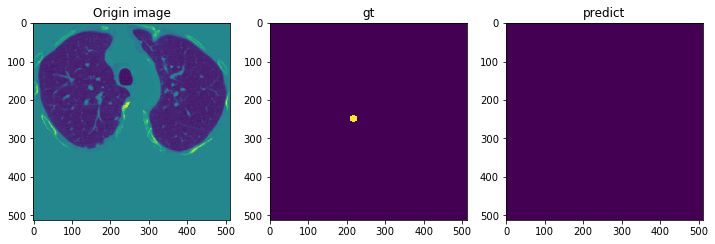

图片的第 80 层


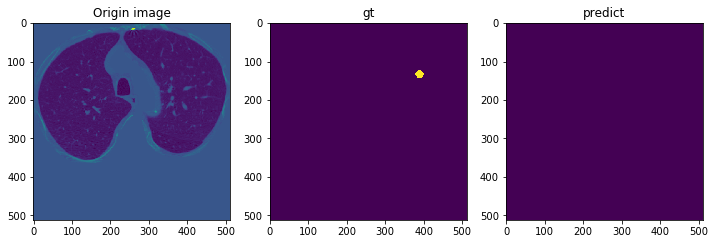

图片的第 81 层


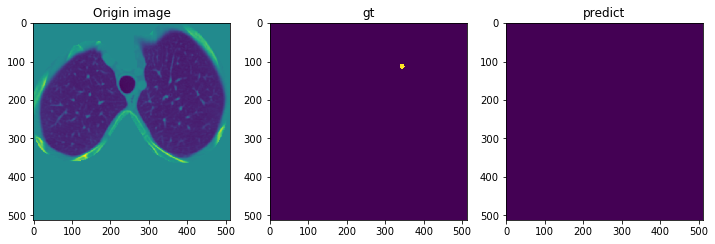

图片的第 82 层


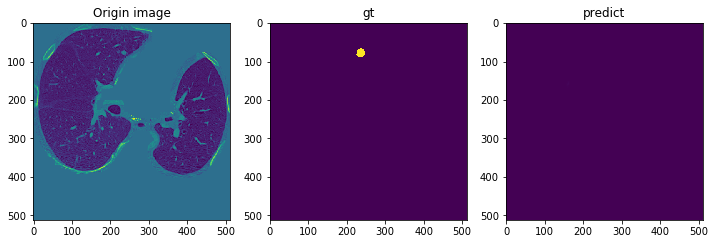

图片的第 83 层


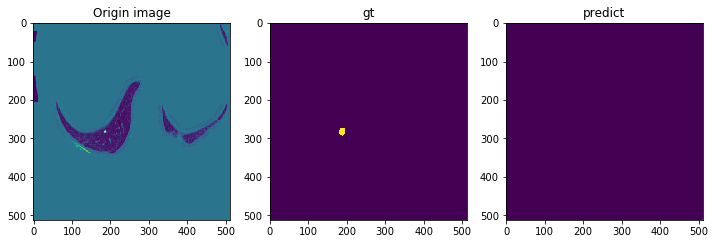

图片的第 84 层


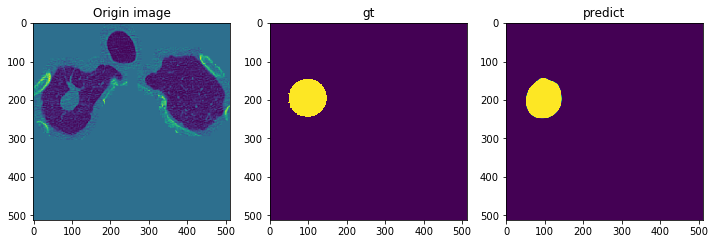

图片的第 85 层


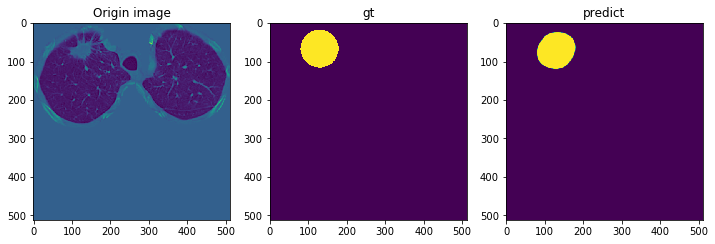

图片的第 86 层


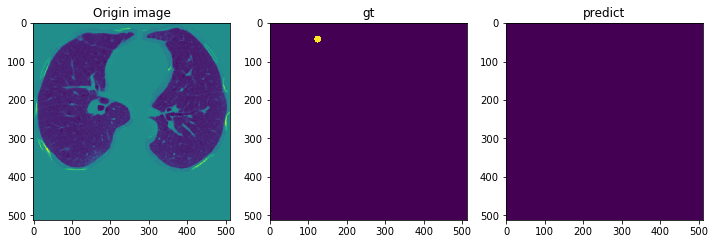

图片的第 87 层


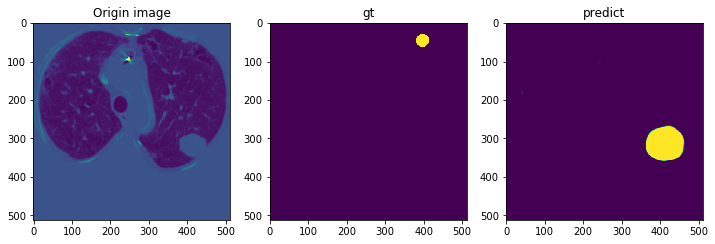

图片的第 88 层


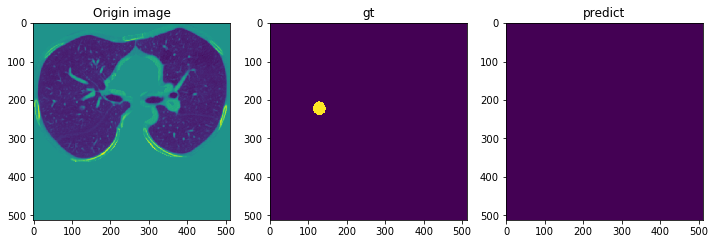

图片的第 89 层


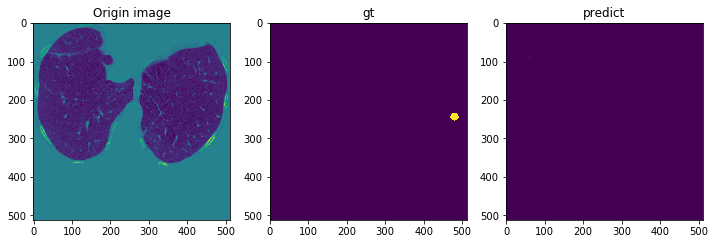

图片的第 90 层


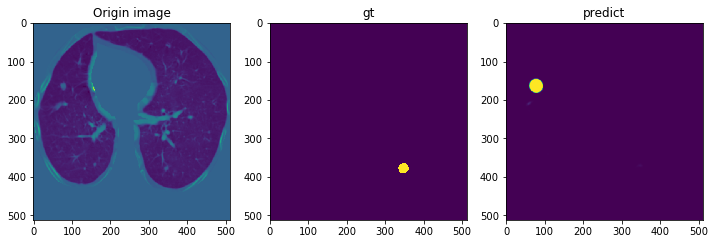

图片的第 91 层


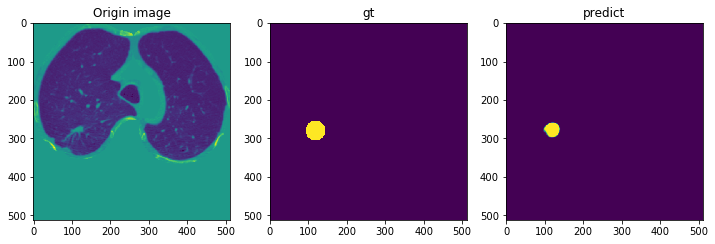

图片的第 92 层


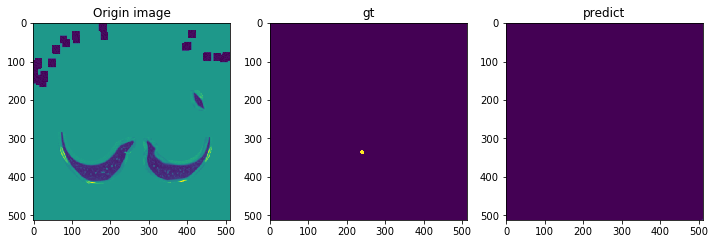

图片的第 93 层


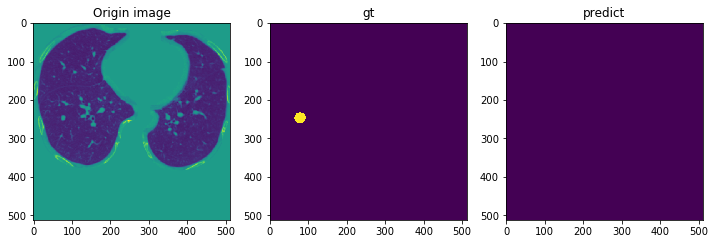

图片的第 94 层


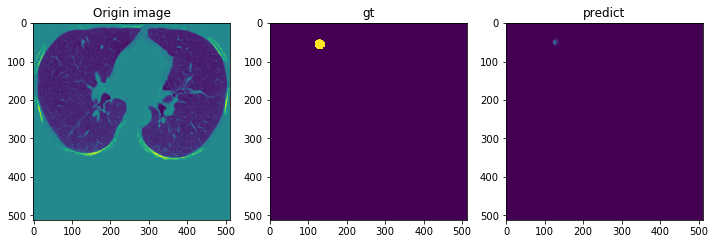

图片的第 95 层


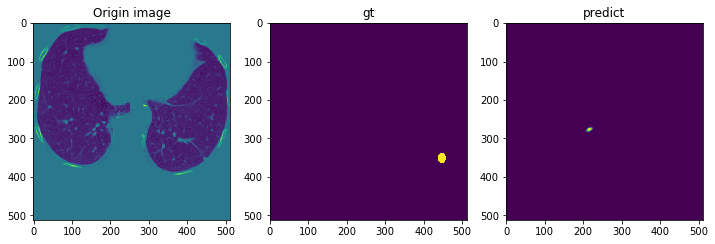

图片的第 96 层


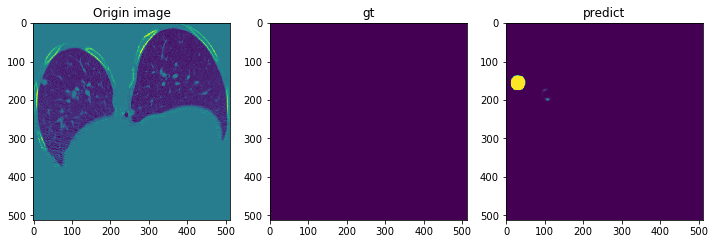

图片的第 97 层


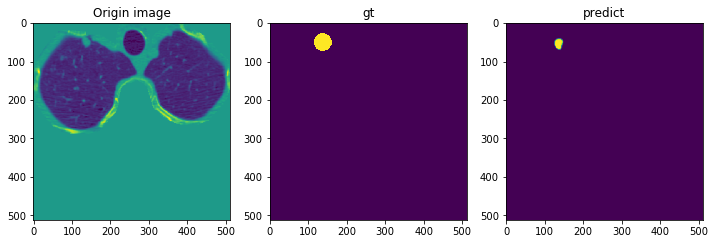

图片的第 98 层


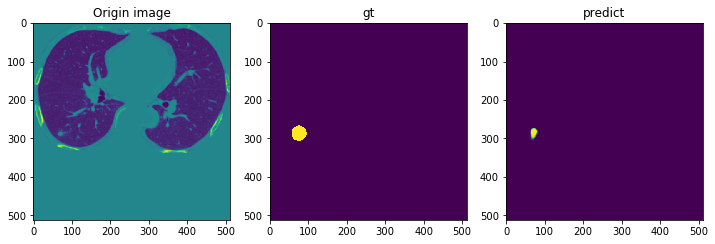

图片的第 99 层


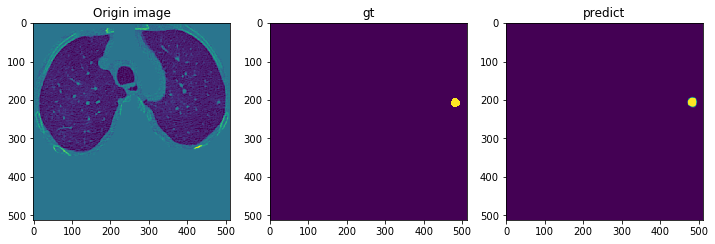

In [12]:
for i in range(100):
    print ("图片的第 %d 层" % i)
    fig,ax = plt.subplots(1,3,figsize=[12,12])
    ax[0].imshow(X_test_r[i,0,:,:])
    ax[0].set_title(u'Origin image')
    ax[1].imshow(Y_test_r[i,0,:,:])
    ax[1].set_title(u'gt')
    ax[2].imshow(imgs_mask_test[i,0,:,:])
    ax[2].set_title(u'predict')
    plt.show()

In [13]:
array_stats(imgs_mask_test)

array shape:  (581, 1, 512, 512) float32
min: 0.0, max: 1.0, avg: 0.00516, std:0.0708
